## Variational method for particle in a box problem

A quantum particle in a box problem is described by the following Schr\''odinger's equation:
$$
\big[-\frac{\hbar^2}{2m}\frac{d^2}{dx^2} + V \big]\psi = E\psi\,.
$$
where $m$, $x$, and $V$ denotes the mass, position, and potential of the particle. $V=0$ for $x\in [0,L]$ and $V=\infty$ elsewhere. The solutions of the equation is given by the eigenfunctions:
$$
\psi_n(x) = \sqrt{\frac{2}{L}}\sin \frac{n\pi x}{L}
$$
with corresponding eigenenergy
$$
E_n = \frac{n\pi^2\hbar^2}{2mL^2}\,.
$$
The minimum energy or the ground state energy is found for $n=1$. Thus
the ground state wavefunction becomes
$$
\psi_0(x) = \sqrt{\frac{2}{L}}\sin \frac{\pi x}{L}
$$
corresponding to the energy
$$
E_0 = \frac{\pi^2\hbar^2}{2mL^2}\,.
$$

If we set $\hbar=m=L=1$, the ground state energy becomes 
$$
E_0 = \frac{\pi^2}{2}=4.935\,.
$$


In [1]:
import sys
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize
Polynomial = np.polynomial.Polynomial
import matplotlib.pyplot as plt
#%matplotlib inline

### Variational approach:

In the variational method we select the trial wavefunction as 

$$
\psi([c],x) = P_N(x) B(x)\,
$$
where
$$P_N(x) = \sum_{i=0}^{N} c_i x^i\,$$
and
$$B(x)=x(L-x)$$ 
satisfying the boundary conditions $\psi(0)=\psi(L)=0$
and $[c]$ denotes a set of coefficients $c_0, \cdots,c_{N-1}$.

For $N=1$,
$$
\psi([c],x) =  c_0 x^0 B(x) = B(x) = c_0 x(L-x)\,.
$$
For $N=1$,
$$
\psi([c],x) =  (c_0 + c_1 x) B(x)\,.
$$
For $N=4$,
$$
\psi([c],x) =  (c_0 + c_1 x + c_2 x^2 + c_3 x^3) B(x)\,.
$$

Another possible trial wavefunction can be
$$
\psi([c],x) = \sum_{i=0}^{N} c_i B(x)^i\,.
$$

<Figure size 800x600 with 0 Axes>

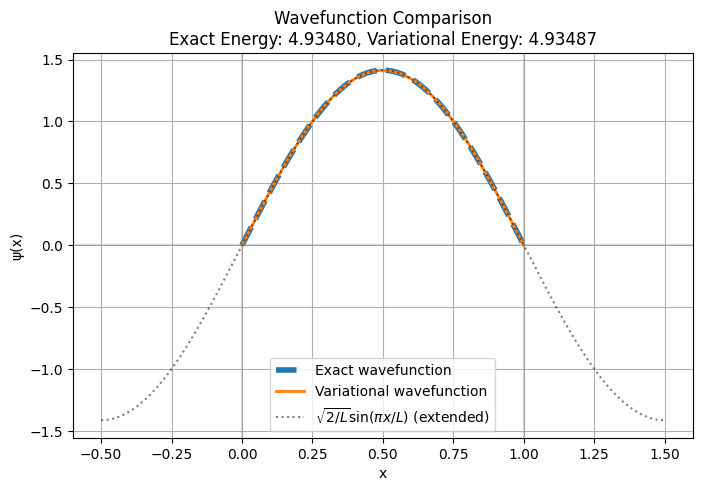

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize

# Define the box length
L = 1.0
N = 3  # Degree of polynomial
choice = 0


# Exact ground state wavefunction and energy
def exact_wavefunction(x):
    return np.sqrt(2 / L) * np.sin(np.pi * x / L)

def exact_energy():
    return (np.pi ** 2) / (2 * L ** 2)

# Trial wavefunction as a polynomial with boundary conditions enforced
def trial_wavefunction(x, coeffs):
    if choice == 0:
      poly = sum(c * x**i for i, c in enumerate(coeffs)) 
      trial = poly * x*(L-x)
    else:
      trial = sum(c * (x*(L-x))**i for i, c in enumerate(coeffs, start=1))  # Skip i=0
    return trial  # Satisfying boundary conditions
  
# Normalization integral
def normalization_integrand(x, coeffs):
    psi = trial_wavefunction(x, coeffs)
    return psi**2

def normalized_wavefunction(x, coeffs):
    norm, _ = quad(normalization_integrand, 0, L, args=(coeffs,))
    return trial_wavefunction(x, coeffs) / np.sqrt(norm)

# Compute expectation values of energy
def kinetic_energy_integrand(x, coeffs):
    # First derivative of the polynomial part
    poly_deriv = sum(i * c * x**(i-1) for i, c in enumerate(coeffs) if i > 0)
    # First derivative of the full trial function (product rule)
    psi_prime = poly_deriv * (x * (L - x)) + sum(c * x**i for i, c in enumerate(coeffs)) * (L - 2*x)
    return 0.5 * psi_prime**2  # This is equivalent to -0.5 psi * psi''

def potential_energy_integrand(x, coeffs):
    return 0  # Potential energy is zero inside the box

# Compute total energy with normalization
def energy_expectation(coeffs):
    # First calculate normalization
    norm, _ = quad(normalization_integrand, 0, L, args=(coeffs,))
    
    # Then calculate kinetic energy
    T, _ = quad(kinetic_energy_integrand, 0, L, args=(coeffs,))
    T = T / norm  # Normalize
    
    V, _ = quad(potential_energy_integrand, 0, L, args=(coeffs,))
    V = V / norm  # Normalize
    
    return T + V

# Initial guess for polynomial coefficients
initial_coeffs = np.random.rand(N+1) # N-degree Polynomial will have N+1 coefficients
                                    # considering the constant term (c_0 x^0).
#initial_coeffs = np.ones(N+1)  # Better than random for stability

# Minimize the energy to find the best coefficients
#result = minimize(energy_expectation, initial_coeffs, method='L-BFGS-B')
result = minimize(energy_expectation, initial_coeffs, method='BFGS')
#result = minimize(energy_expectation, initial_coeffs, method='Powell')

coeffs_opt = result.x

# Compute energies
e_exact = exact_energy()
e_var = energy_expectation(coeffs_opt)



# PLOTTING ------------>
plt.figure(figsize=(8, 6))  

# Plot the wavefunctions
x_vals = np.linspace(0, L, 100)
#x_box = np.linspace(0, L, 100)
x_extended = np.linspace(-0.5, 1.5, 200)  # Extend beyond the box
psi_exact = exact_wavefunction(x_vals)
psi_exact_extended = exact_wavefunction(x_extended)

# Calculate normalized variational wavefunction
norm, _ = quad(normalization_integrand, 0, L, args=(coeffs_opt,))
psi_variational = np.array([trial_wavefunction(x, coeffs_opt)/np.sqrt(norm) for x in x_vals])


plt.figure(figsize=(8, 5))
plt.plot(x_vals, psi_exact, label="Exact wavefunction", linestyle='dashed', linewidth=4)
plt.plot(x_vals, psi_variational, label="Variational wavefunction", linewidth=2)

# Outside the box (sinusoidal extension)
plt.plot(x_extended, psi_exact_extended, 'k:', label="$\sqrt{2/L}\sin(\pi x/L)$ (extended)", alpha=0.5)

# Box boundaries
plt.axvline(0, color='gray', linestyle='-', alpha=0.3)
plt.axvline(L, color='gray', linestyle='-', alpha=0.3)
plt.axhline(0, color='gray', linestyle='-', alpha=0.3)


plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.title(f"Wavefunction Comparison\nExact Energy: {e_exact:.5f}, Variational Energy: {e_var:.5f}")
plt.legend()
plt.grid()
plt.show()